In [ ]:
#Uploading and Unzip the Dataset
import os
import zipfile

# 1. Unzip the file

local_zip = '/content/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

print("Dataset unzipped successfully!")

# 2. Check the folder structure

base_dir = '/content/dataset'
print("Contents of base directory:")
print(os.listdir(base_dir))

Dataset unzipped successfully!
Contents of base directory:
['Revitsone-5classes', 'revitsone-5classes']


In [ ]:
import os

# Check the first folder
path1 = '/content/dataset/Revitsone-5classes'
print(f"--- Checking: {path1} ---")
if os.path.exists(path1):
    print(os.listdir(path1))
else:
    print("Folder not found.")

print("\n")

# Check the second folder
path2 = '/content/dataset/revitsone-5classes'
print(f"--- Checking: {path2} ---")
if os.path.exists(path2):
    print(os.listdir(path2))
else:
    print("Folder not found.")

--- Checking: /content/dataset/Revitsone-5classes ---
['turning', 'talking_phone', 'other_activities', 'texting_phone', 'safe_driving']


--- Checking: /content/dataset/revitsone-5classes ---
['Revitsone-5classes']


/tmp/ipython-input-1505253899.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()), palette='viridis')


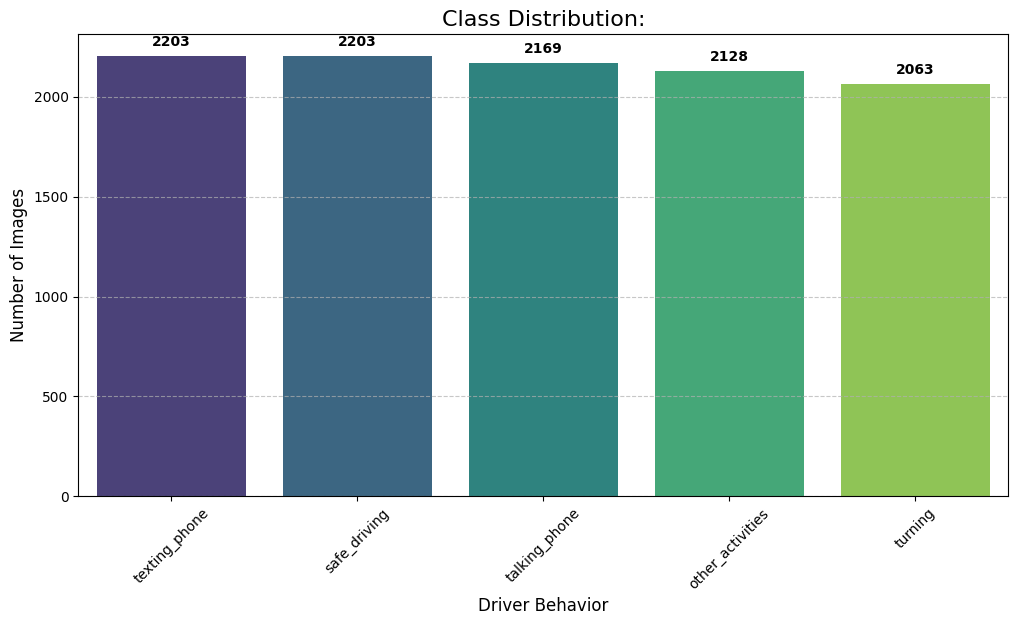

In [ ]:
#EDA - Class Distribution
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Set the path
base_dir = '/content/dataset/Revitsone-5classes'

# 1. Count the images
class_counts = {}
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        class_counts[folder] = count

# 2. Plot
plt.figure(figsize=(12, 6))
# Sort the data for a cleaner look
sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()), palette='viridis')
plt.title('Class Distribution:', fontsize=16)
plt.xlabel('Driver Behavior', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add actual numbers on top of bars
for i, v in enumerate(sorted_counts.values()):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.show()

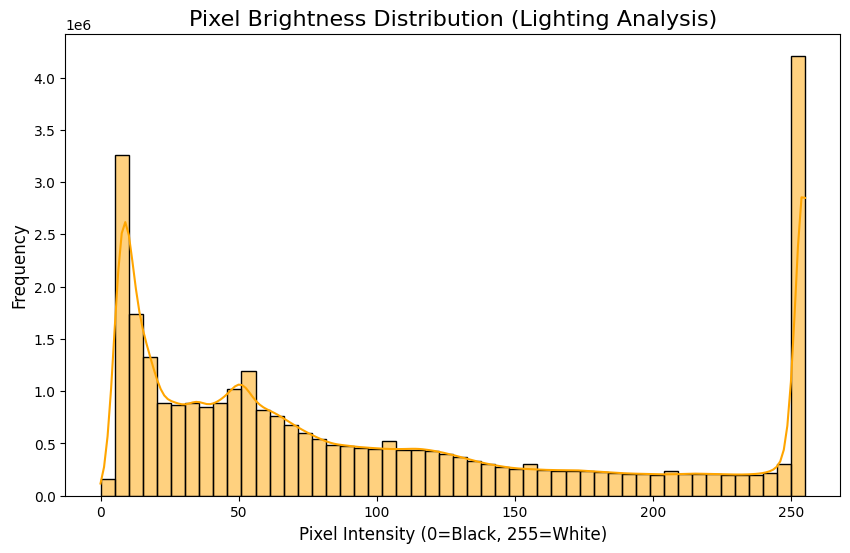

In [ ]:
# EDA - Brightness Histogram
import cv2
import numpy as np

# A random sample of 100 images to calculate the average brightness
brightness_values = []
all_files = []

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path)[:20]: # Take top 20 from each class
            all_files.append(os.path.join(folder_path, file))

for img_path in all_files:
    try:
        img = cv2.imread(img_path)
        if img is not None:
            # Convert to HSV color space, extract V (Value/Brightness) channel
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            brightness_values.extend(hsv[:,:,2].flatten())
    except:
        pass

# Plot Histogram
plt.figure(figsize=(10, 6))
sns.histplot(brightness_values, bins=50, color='orange', kde=True)
plt.title('Pixel Brightness Distribution (Lighting Analysis)', fontsize=16)
plt.xlabel('Pixel Intensity (0=Black, 255=White)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

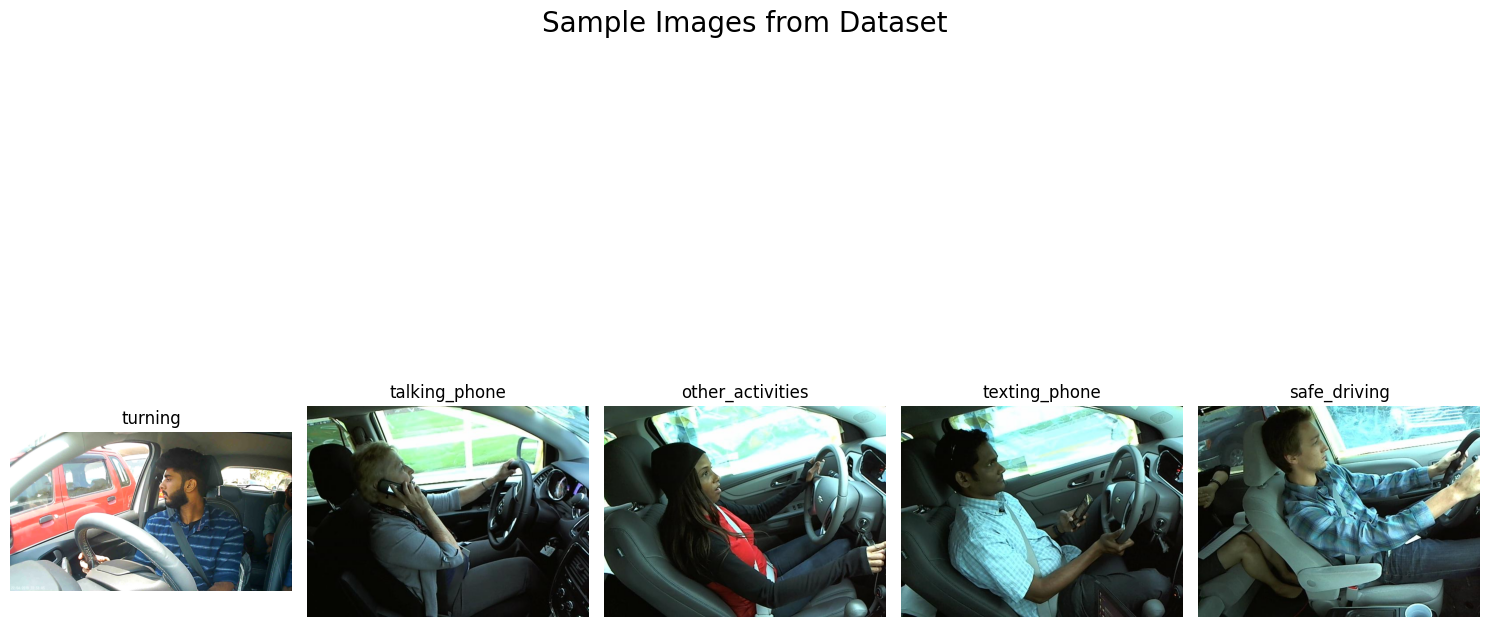

In [ ]:
# EDA - Sample Visualization Grid
import random

classes = list(class_counts.keys())
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(classes):
    folder_path = os.path.join(base_dir, class_name)

    # Pick a random image
    if os.path.exists(folder_path):
        img_file = random.choice(os.listdir(folder_path))
        img_path = os.path.join(folder_path, img_file)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i+1) # 1 row, 5 columns
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.suptitle("Sample Images from Dataset", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os



base_dir = '/content/dataset/Revitsone-5classes'


print(f"Using Base Directory: {base_dir}")

# Check
if not os.path.exists(base_dir) or not any(os.path.isdir(os.path.join(base_dir, d)) for d in os.listdir(base_dir)):
    print("WARNING: This directory seems wrong. Please check the 'base_dir' variable above!")
else:
    print("Directory looks good! Found classes:", os.listdir(base_dir))

# --- DATA GENERATORS (The rest is standard) ---
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Class Mappings:", train_generator.class_indices)

Using Base Directory: /content/dataset/Revitsone-5classes
Directory looks good! Found classes: ['turning', 'talking_phone', 'other_activities', 'texting_phone', 'safe_driving']
Found 8604 images belonging to 5 classes.
Found 2147 images belonging to 5 classes.
Class Mappings: {'other_activities': 0, 'safe_driving': 1, 'talking_phone': 2, 'texting_phone': 3, 'turning': 4}


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

# 1. Load the Base Model (Pre-trained on ImageNet)
# We exclude the top because we want to add our own 5 classes
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# 2. Add the custom head for YOUR dataset
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel) # Prevents overfitting
headModel = Dense(5, activation="softmax")(headModel) # 5 Output Classes

# 3. Combine them
model = Model(inputs=baseModel.input, outputs=headModel)

# 4. Freeze the base model (We only want to train the new head first)
for layer in baseModel.layers:
    layer.trainable = False

# 5. Compile
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print("Model constructed and ready for training!")

/tmp/ipython-input-3593272657.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


Model constructed and ready for training!


In [ ]:
#Dataset Cleaner
import os
from PIL import Image

# Define base directory again to be safe
base_dir = '/content/dataset/Revitsone-5classes'

print("Checking for corrupt images...")
deleted_count = 0

# Walk through all folders
for subdir, dirs, files in os.walk(base_dir):
    for file in files:
        filepath = os.path.join(subdir, file)

        try:
            # Try to open the image
            img = Image.open(filepath)
            img.verify() # Verify it's a real image
            img.close()
            # Re-open to checking loading (verify doesn't catch truncation)
            img = Image.open(filepath)
            img.load()
            img.close()

        except (IOError, SyntaxError) as e:
            # If it fails, delete it
            print(f"BAD FILE DETECTED & DELETED: {filepath}")
            os.remove(filepath)
            deleted_count += 1

print(f"\nScan complete. Deleted {deleted_count} corrupt files.")

Checking for corrupt images...
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/turning/img_67523.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/turning/img_62337.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/turning/img_101434.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/turning/img_8771.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/turning/img_84605.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/turning/img_70552.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/other_activities/img_13396.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/other_activities/img_13318.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/other_activities/img_4664.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes/other_activities/img_22266.jpg
BAD FILE DETECTED & DELETED: /content/dataset/Revitsone-5classes

In [ ]:
EPOCHS = 10
print(f"Starting training for {EPOCHS} epochs...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=EPOCHS
)

Starting training for 10 epochs...
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 165s 552ms/step - accuracy: 0.3824 - loss: 1.5123 - val_accuracy: 0.6936 - val_loss: 0.9323
Epoch 2/10
  1/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4688 - loss: 1.1873

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.4688 - loss: 1.1873 - val_accuracy: 0.6978 - val_loss: 0.9321
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 131s 489ms/step - accuracy: 0.6304 - loss: 0.9349 - val_accuracy: 0.7299 - val_loss: 0.7820
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.7188 - loss: 0.8704 - val_accuracy: 0.7407 - val_loss: 0.7590
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 132s 492ms/step - accuracy: 0.6968 - loss: 0.7978 - val_accuracy: 0.7505 - val_loss: 0.7064
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.7188 - loss: 0.7066 - val_accuracy: 0.7486 - val_loss: 0.6983
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 174s 490ms/step - accuracy: 0.7196 - loss: 0.7146 - val_accuracy: 0.7682 - val_loss: 0.6942
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.8125 - loss: 0.4966 - val_accuracy: 0.7938 - val_loss: 0.6586
Epoch 9/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 132s 493ms/step - accuracy: 0.7436 - loss: 0.6619 -

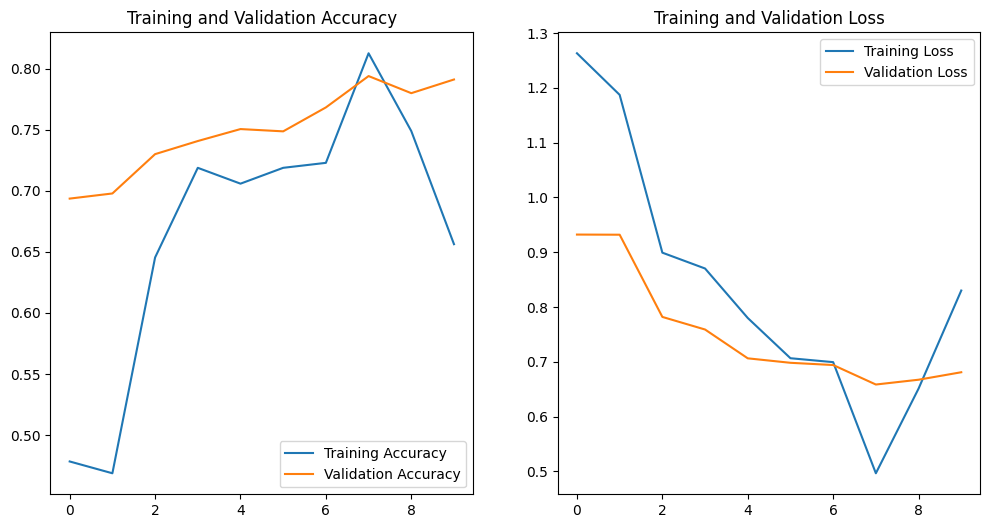

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 1. Unfreeze the base model
baseModel.trainable = True

# 2. Freezing the bottom layers (we keep the basic shapes/edges frozen)

print(f"Total layers in base model: {len(baseModel.layers)}")

fine_tune_at = 120

for layer in baseModel.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Re-compile with a VERY LOW learning rate
# This is important! If the rate is too high, it will destroy the pre-trained weights.
from tensorflow.keras.optimizers import Adam

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-5), # Very slow learning
              metrics=["accuracy"])

print("Model re-compiled for fine-tuning.")

# 4. Train for 5 more epochs
fine_tune_epochs = 5
total_epochs = 10 + fine_tune_epochs # 10 from before + 5 new ones

print("Starting Fine-Tuning...")
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=fine_tune_epochs
)

Total layers in base model: 154
Model re-compiled for fine-tuning.
Starting Fine-Tuning...
Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 147s 516ms/step - accuracy: 0.7659 - loss: 0.6236 - val_accuracy: 0.8064 - val_loss: 0.6158
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.8125 - loss: 0.4560 - val_accuracy: 0.8088 - val_loss: 0.6128
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 130s 483ms/step - accuracy: 0.7893 - loss: 0.5651 - val_accuracy: 0.8041 - val_loss: 0.6259
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - accuracy: 0.7500 - loss: 0.5979 - val_accuracy: 0.7962 - val_loss: 0.6378
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 130s 486ms/step - accuracy: 0.8036 - loss: 0.5344 - val_accuracy: 0.8074 - val_loss: 0.6114


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the final high-accuracy model
model.save('/content/drive/My Drive/driver_behavior.h5')
print("Final High-Accuracy Model saved to Google Drive!")

Mounted at /content/drive
Final High-Accuracy Model saved to Google Drive!
